# Localization Examples

This notebook demonstrates how to implement and use the base classes from the localization modules. Their strengths, weaknesses, and performance is examined using a two-dimensional Cartesian plane example similar to the examples found [here](https://www.kalmanfilter.net/multiExamples.html). We will use an scenario similar to example 9.

Assume a vehicle is traveling in an plane and that the vehicle can be modeled as a point mass with three degrees of freedom (two translational and one rotational). The vehicle has a sensor on board that reports the range and bearing of a landmark located at the origin as well as an inertial measurment unit that can measure accelerations in the body frame (along, athwart, and rotational).

**General State Equation**

As a refresher, the general form of the state equation is

\begin{equation}
\textbf{x}_{t+1} = \textbf{F} \textbf{x}_t + \textbf{B} \textbf{u}_t + \textbf{w}_t
\end{equation}

Where:
* $\textbf{x}_{t+1}$ is the predicted system state
* $\textbf{x}_t$ is the current estimated system state
* $\textbf{u}_t$ is the current control input
* $\textbf{F}$ is the state transition matrix, sometimes noted as $\textbf{A}$
* $\textbf{B}$ is the control input matrix, sometimes noted as $\textbf{G}$

Note, in my notation bold-faced lowercase symbols are vectors, bold-faced uppercase symbols are matricies. Non-bold versions of the same symbol will indicate an element of that matrix or vector quantity. Ex: $x_t^i$ is the *i*-th element of the vector $\textbf{x}_t$. In this scenario our state vector becomes the position along the world x- and y-axes, and the angular position, velocity, and acceleration of the body frame x-axis relative to the world x-axis, and the body frame velocities ($v_x$, and $v_y$) and accelerations ($a_x$, and $a_y$).

\begin{equation}
\textbf{x}_t = [p_x, p_y, v_x, v_y, a_x, a_y, \theta, \omega, \alpha ]
\end{equation}

**General Dynamic Model**

From basic planar dynamics we can write the following equations assuming a constant acceleration model, where $t$ is the time duration from one step to another:

* $p_x' = p_x + \left(v_x \cos\theta + v_y \cos(\frac{\pi}{2} - \theta)\right) t + 0.5 \left(a_x \cos\theta + a_y \cos(\frac{\pi}{2} - \theta) \right) t^2$
* $p_y' = p_y + \left(v_x \sin\theta + v_y \sin(\frac{\pi}{2} - \theta)\right) t + 0.5 \left(a_x \sin\theta + a_y \cos(\frac{\pi}{2} - \theta) \right) t^2$
* $v_x' = v_x + a_x t$
* $v_y' = v_y + a_y t$
* $\theta ' = \theta + \omega t + 0.5 \alpha t^2$
* $\omega ' = \omega + \alpha t$

As you can see, for a relatively simple case of three degrees of freedom planar motion, this is already getting to be a complicated non-linear model. We'll make one simplifying assumption that there is no side-slippage in the system ($v_y = 0$, and $a_y = 0$) and that the linear velocity and acceleration is only along the body frame x-axis. While this reduces some complexity, it still leaves us with two non-linear terms in the position equations:

* $p_x' = p_x + \left(v t  + 0.5 a t^2\right) \cos\theta$
* $p_y' = p_y + \left(v t + 0.5 a t^2\right) \sin\theta$
* $v' = v + a t$
* $\theta ' = \theta + \omega t + 0.5 \alpha t^2$
* $\omega ' = \omega + \alpha t$

## Kalman Filter

### Basic Theory

The Kalman Filter consists of two equations that describe how the mean ($\textbf{x}_t$) and covariance ($\textbf{P}_t$) of a Guassian distribution based on the above state equation evolve over time with respect to a measurement vector $\textbf{z}_t$. However, it is frequently expanded to seven equations for readability and broken into two distinct phases: the prediction phase and the update phase.

**Prediction**
1. $\hat{\textbf{x}}_t = \textbf{F} \textbf{x}_t + \textbf{B} \textbf{u}_t$
2. $\hat{\textbf{P}}_t = \textbf{F} \textbf{P}_t \textbf{F}^T + \textbf{Q}$

**Update**
1. $\textbf{y} = \textbf{z}_t - \textbf{H} \hat{\textbf{x}}_t$
2. $\textbf{S} = \textbf{H} \hat{\textbf{P}} \textbf{H}^T + \textbf{R}$
3. $\textbf{K} = \hat{textbf{P}}_t \textbf{H}^T \textbf{S}^-1$
4. $\textbf{x}_{t+1} = \hat{\textbf{x}}_t + \textbf{K} \textbf{y}$
5. $\textbf{P}_{t+1} = \left(\textbf{I} - \textbf{K}\textbf{H}\right) \hat{\textbf{P}}$

The Kalman Filter assumes that system is linear. Therfore, to implement a Kalman Filter for this scenario, we will have to make some changes due to the non-linearities in the position equations and how the measurement is provided. The measurement is pretty simple: instead of directly providing the range and bearing ($\textbf{z} = \left[r, \phi\right]$) to the origin, preprocess the measurement using the IMU's heading angle to calculate the position. 

\begin{equation}
\bar{\textbf{z}}(\theta) = \left[r \cos\left(\theta + \phi\right), r \sin\left(\theta + \phi\right) \right]
\end{equation}

Instead of passing the body-frame accelerations directly into the state equation, we will assume that there is some pre-processing done with the inertial measurement unit that converts the accelerations into the world coordinate frame. We can now use the Kalman Filter two different ways to estimate the state of the vehicle: first by not using the IMU and assuming a constant-acceleration model that includes acceleration in the state vector; second: using the same model but treating the accelerations as control inputs that are measured using the IMU.

### Without control inputs

In this framework our state vector becomes $x_t = \left[p_x, \dot{p}_x, \ddot{p}_x, p_y, \dot{p}_y, \ddot{p}_y \right]$. Our state transition matrix $\textbf{F}$ is therefore just a matrix representation of the one dimensional kinematics equations:

$\textbf{F} = \left[ \begin{matrix}
                1 & t & 0.5 t^2 & 0 & 0 & 0 \\
                0 & 1 & t       & 0 & 0 & 0 \\
                0 & 0 & 1       & 0 & 0 & 0 \\
                0 & 0 & 0 & 1 & t & 0.5 t^2 \\
                0 & 0 & 0 & 0 & 1 & t       \\
                0 & 0 & 0 & 0 & 0 & 1       
              \end{matrix}\right]$

The control input matrix $\textbf{B}$ and vector $\textbf{u}_t$ are simply zero. The measurement matrix $\textbf{H}$ is similarly simple:

$\textbf{H} = \left[
    \begin{matrix}
    1 & 0 \\
    0 & 0 \\
    0 & 0 \\
    0 & 1 \\
    0 & 0 \\
    0 & 0 \\
    \end{matrix}
\right]$

The only remaining unknowns are the process noise matrix $\textbf{Q}$ and the measurement uncertainty matrix ($\textbf{R}$). The measurement uncertainty matrix is relatively simple to construct as it is simply a covariance formulation of the measurement accuracy which can be treated as a standard deviation. For example a distance measurement that is accurate to $\pm\sigma$ would result in an $\textbf{R} = \sigma^2$. Typically, these values should only be along the diagonal unless there is some sort of cross-correlation relationship.

This process noise matrix can be calculated using two different methods depending on whether or not you have control inputs. Since we do not in this case, we will calculate it using the state transition matrix. This method first requires determining your noise parameters ($\sigma^2$), and how they map to the state state transition matrix ($\bar{\textbf{Q}}$). Typically the noise parameter is placed on the highest order derivative. The noise parameter(s) can be brought in through sensor specifications (ex: if a sensor reports a measurement $z$ accurate to $\pm \sigma$) or just left as scalar of one. Putting the noise on the acceleration only we get:

\begin{equation}
\bar{\textbf{Q}} = \left[\begin{matrix} 0 & 0 & 0 \\ 0 & 0 & 0 \\ 0 & 0 & 1 \end{matrix}\right] \sigma^2
\end{equation}

We can then calculate the process noise using the state transition matrix as such: $\textbf{Q} = \textbf{F} \bar{\textbf{Q}} \textbf{F}^T$. In this scenario this results in the following matrix:

\begin{equation}
\textbf{Q} = \left[
             \begin{matrix} 
                \frac{t^4}{4} & \frac{t^3}{2} & \frac{t^2}{2} & 0             & 0             & 0 \\
                \frac{t^3}{2} & t^2           & t             & 0             & 0             & 0 \\
                \frac{t^2}{2} & t             & 1             & 0             & 0             & 0 \\
                0             & 0             & 0             & \frac{t^4}{4} & \frac{t^3}{2} & \frac{t^2}{2} \\
                0             & 0             & 0             & \frac{t^3}{2} & t^2           & t             \\   
                0             & 0             & 0             & \frac{t^2}{2} & t             & 1 \\
             \end{matrix}
            \right]
\end{equation}

### With control inputs

We can thus model our system with the following state vector $ x_t = \left[p_x, \dot{p}_x, p_y, \dot{p}_y, \right]$ and treat the measured accelerations as control inputs: $u_t = \left[\ddot{p}_x, \ddot{p}_y \right]$.

In turn, our state transition matrix $\textbf{F}$ becomes:

$ \textbf{F} = \left[ 
    \begin{matrix}
        1 & t & 0 & 0 \\
        0 & 1 & 0 & 0 \\
        0 & 0 & 1 & t \\
        0 & 0 & 0 & 1 \\
    \end{matrix}
 \right]$

and the control input matrix $\textbf{B}$ becomes:
$\textbf{B} = \left[ 
    \begin{matrix}
    0.5t^2 & 0 \\
    t      & 0 \\
    0      & 0.5t^2 \\
    0      & t
    \end{matrix}
\right]$

We can similarly calculate the process noise matrix, however this time we use the control input matrix: $\textbf{Q} = \textbf{B} \sigma^2 \textbf{B}^T$. The measurement uncertainty matrix remains the same and $\textbf{H}$ matrix remain the same.

## Testing the Kalman Filter

Now on to testing the Kalman Filter. We will have a truth trajectory that resembles something like a J-shape at a 45 degree angle from the x-axis.

In [32]:
import numpy as np

In [102]:
# set constants and initial conditions
v = 0.1 #m/s
q = np.pi/4
w = 0
x = 0
y = 0
vx = np.cos(q)*v
vy = np.sin(q)*v
truth = {'time': [], 'x': [], 'y':[], 'q':[], 'vx':[], 'vy':[], 'w':[]}
measurements = {'r':[], 'phi':[]}
t = 0
dt = 1
# straight line trajectory
while t < 30*60:
    truth['time'].append(t)
    truth['x'].append(x)
    truth['y'].append(y)
    truth['q'].append(q)
    truth['vx'].append(vx)
    truth['vy'].append(vy)
    measurements['r'].append(np.sqrt(x*x + y*y))
    '''try:
        measurements['phi'].append(np.arctan(-x/-y))
    except:
        measurements['phi'].append(np.arctan(-x))'''
    measurements['phi'].append(-np.arctan2(-x, -y) - q)
    x += v*dt*np.cos(q)
    y += v*dt*np.sin(q)
    q += w*dt
    vx = np.cos(q)*v
    vy = np.cos(q)*v
    t+=dt

# half circle trajectory
w = (np.pi/2)/(30*60) # pi radians per 30 minutes
while t < 60*60:
    truth['time'].append(t)
    truth['x'].append(x)
    truth['y'].append(y)
    truth['q'].append(q)
    truth['vx'].append(vx)
    truth['vy'].append(vy)
    measurements['r'].append(np.sqrt(x*x + y*y))
    measurements['phi'].append(-np.arctan2(-x, -y) - q)
    x += v*dt*np.cos(q)
    y += v*dt*np.sin(q)
    q += w*dt
    vx = np.cos(q)*v
    vy = np.cos(q)*v
    t+=dt

Text(0.5, 1.0, 'Truth Position')

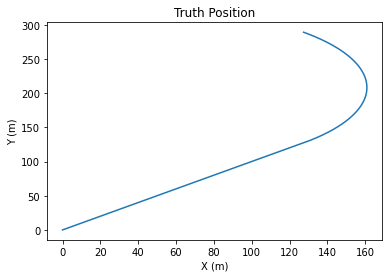

In [103]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(truth['x'], truth['y'])
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Truth Position')

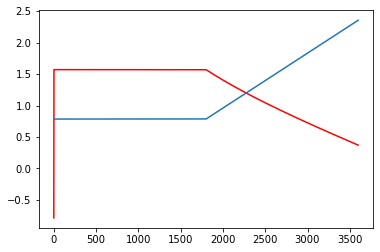

In [104]:
plt.plot(truth['time'], measurements['phi'], '-r', truth['time'], truth['q'])

In [108]:
a = np.array([12])
a.shape

(1,)

In [112]:
np.eye(3) * [12, 12, 13]

array([[12.,  0.,  0.],
       [ 0., 12.,  0.],
       [ 0.,  0., 13.]])

In [134]:
B = np.array([0.12])

In [127]:
B @ np.array([[1, 2],[3,4],[5,6]]) @ B.T

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 2)

In [136]:
B *np.eye(5) 

array([[0.12, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.12, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.12, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.12, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.12]])